### Import related package

In [1]:
## Import tensorflow package for modeling
import tensorflow as tf

## Data processing
import pandas as pd
import numpy as np

## Min-max normalization
from sklearn.preprocessing import MinMaxScaler

## Plot the graph
import matplotlib.pyplot as plt
%matplotlib inline

## Initializing module
from sklearn.linear_model import LinearRegression
np.set_printoptions(suppress=True)

## Copy module
import copy

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


### Control memory usage space for GPU

In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.3)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))
tf.compat.v1.keras.backend.set_session(sess)

### Preprocessing the data

In [3]:
def read(path):
    return pd.read_csv(path)

In [4]:
def buildTrain(train, pastWeek=4, futureWeek=4, defaultWeek=1):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-futureWeek-pastWeek):
        X = np.array(train.iloc[i:i+defaultWeek])
        X = np.append(X,train["CCSP"].iloc[i+defaultWeek:i+pastWeek])
        X_train.append(X.reshape(X.size))
        Y_train.append(np.array(train.iloc[i+pastWeek:i+pastWeek+futureWeek]["CCSP"]))
    return np.array(X_train), np.array(Y_train)

### Min-max normalization

In [5]:
## Use min-max normalization to scale the data to the range from 1 to 0
sc = MinMaxScaler(feature_range = (0, 1))

### Design get_data() to get data

In [6]:
def get_data(futureWeek):
    
    ## Read weekly copper price data
    path = "WeeklyFinalData.csv"
    data = read(path)
    
    date = data["Date"]
    data.drop("Date", axis=1, inplace=True)
    
    ## Add time lag (pastWeek=4, futureWeek=1)
    x_data, y_data = buildTrain(data, futureWeek=futureWeek)
    
    ## Split the data to training data and test data
    x_train_data = x_data[:int(x_data.shape[0]*0.8)]
    x_test_data = x_data[int(x_data.shape[0]*0.8):]
    y_train_data = y_data[:int(x_data.shape[0]*0.8)]
    y_test_data = y_data[int(x_data.shape[0]*0.8):]


    return (x_train_data, x_test_data, y_train_data, y_test_data)

### Network class

In [7]:
class Network():
    
    def __init__(self, nb_neuro, x_train_scaled, y_train_scaled):
        
        # Stop criteria - threshold
        self.threshold_for_error = 0.07
        self.threshold_for_lr = 1e-6
        
        # Input data 
        self.x = tf.convert_to_tensor(x_train_scaled, np.float32)
        self.y = tf.convert_to_tensor(y_train_scaled, np.float32)
        
        # Learning rate
        self.learning_rate = 1e-2
        
        
        # Hidden layer I
        self.n_neurons_in_h1 = nb_neuro
        self.W1 = tf.Variable(tf.random.truncated_normal([self.x.shape[1], self.n_neurons_in_h1], mean=0, stddev=1))
        self.b1 = tf.Variable(tf.random.truncated_normal([self.n_neurons_in_h1], mean=0, stddev=1))

        # Output layer
        self.Wo = tf.Variable(tf.random.truncated_normal([self.n_neurons_in_h1, self.y.shape[1]], mean=0, stddev=1))
        self.bo = tf.Variable(tf.random.truncated_normal([self.y.shape[1]], mean=0, stddev=1))

        # Whether the network is acceptable, default as False
        self.acceptable = False
    
    ## Forecast the test data
    def forecast(self, x_test_scaled):
    
        x_test_scaled = tf.cast(x_test_scaled, tf.float32)
        activation_value = tf.nn.relu((tf.matmul(x_test_scaled, self.W1)+self.b1))
        forecast_value = tf.matmul(activation_value,self.Wo)+self.bo
       
        return forecast_value

    ## Reset the x and y data
    def setData(self, x_train_scaled, y_train_scaled):
        self.x = tf.convert_to_tensor(x_train_scaled, np.float32)
        self.y = tf.convert_to_tensor(y_train_scaled, np.float32)
    
    ## Add the new data to the x and y data
    def addData(self, new_x_train, new_y_train):

        self.x = tf.concat([self.x, new_x_train.reshape(1,-1)],0)
        self.y = tf.concat([self.y, new_y_train.reshape(1,-1)],0)
    
    ## forward operation
    def forward(self,  reg_strength= 0):
        with tf.GradientTape() as tape:

            y1 = tf.nn.relu((tf.matmul(self.x, self.W1)+self.b1))
            yo = (tf.matmul(y1,self.Wo)+self.bo)

            # performance measure
            diff = yo-self.y
            loss = tf.reduce_mean(diff**2) + (reg_strength/(self.Wo.shape[1]*(self.Wo.shape[0]+1)+self.W1.shape[1]*(self.W1.shape[0]+1))) * ((tf.nn.l2_loss(self.W1) + tf.nn.l2_loss(self.Wo) + tf.nn.l2_loss(self.b1) + tf.nn.l2_loss(self.bo))*2)

        return(yo, loss, tape)

    # backward operation
    def backward_Adam(self,tape,loss):

        optimizer = tf.optimizers.Adam(self.learning_rate)
        gradients = tape.gradient(loss, [self.W1, self.Wo, self.b1, self.bo])
        optimizer.apply_gradients(zip(gradients, [self.W1, self.Wo, self.b1, self.bo]))
    
    def backward_RMS(self,tape,loss):

        optimizer = tf.keras.optimizers.RMSprop(self.learning_rate)
        gradients = tape.gradient(loss, [self.W1, self.Wo, self.b1, self.bo])
        optimizer.apply_gradients(zip(gradients, [self.W1, self.Wo, self.b1, self.bo]))

### Initializing module (Check)

In [8]:
def initializing(network, initial_x, initial_y):
    
    ## Find each minimum output value y
    min_y = tf.reduce_min(initial_y, axis=0)
    
    ## Subtract min_y from each y
    res_y = initial_y-min_y
    
    ## Use linear regression to find the initial W1,b1,Wo,bo
    reg = LinearRegression().fit(initial_x, res_y)

    ## Set up the initial parameter of the network
    network.W1 = tf.Variable(tf.cast(tf.transpose(reg.coef_), tf.float32))
    network.b1 = tf.Variable(tf.convert_to_tensor(reg.intercept_, tf.float32))
    network.Wo = tf.Variable(tf.convert_to_tensor([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]], tf.float32))
    network.bo = tf.Variable(tf.cast(min_y, tf.float32))

    ## Set up the acceptable of the initial network as True
    network.acceptable =True

### Selecting module (Check)

In [9]:
def selecting(network, x_train_scaled, y_train_scaled):
    
    
    loss = []
    temp_network = copy.deepcopy(network)
    
    ## Put each data into network to calculate the loss value
    for i in range(x_train_scaled.shape[0]):
        temp_network.setData(x_train_scaled[i].reshape(1,-1), y_train_scaled[i].reshape(1,-1))
        loss.append((temp_network.forward()[1].numpy(),i))

    ## Sort the data according to the loss value from smallest to largest, and save the data index in sorted_index
    sorted_index = [sorted_data[1] for sorted_data in sorted(loss, key = lambda x:x[0])]

    ## Print out some info for debug
    print("First:",loss[sorted_index[0]])
    print("Selecting module finish!")
    
    return sorted_index

### Matching module (Check)

In [10]:
def matching(network):

    ## Set up the learning rate of the network
    network.learning_rate = 1e-3
    

    while True:
        
        ## Get the loss value of the current network architecture
        yo, loss, tape = network.forward()

        ## Identify that all forecast value has met the error term
        if tf.reduce_all(tf.math.abs(yo-network.y) <= network.threshold_for_error):
            
            ## If true, set the acceptable of the network as true and return it
            network.acceptable = True
            print("Matching finished - the network is acceptable")
            return(network)


        ## If the error is not satisfied, continue to tunning the learning rate of the network
        else:
            
            # Save the current papameter
            network_pre = copy.deepcopy(network)
            
            # Stroe the last loss value
            loss_pre = loss
            
            # Backward and check the loss performance of the network with new learning rate
            network.backward_Adam(tape,loss)
            yo, loss, tape = network.forward()

            # Confirm whether the loss value of the adjusted network is smaller than the current one
            if loss < loss_pre:

                # If true, multiply the learning rate by 1.2
                network.learning_rate *= 1.2

            # On the contrary, reduce the learning rate
            else:         
                
                # Identify whether the current learning rate is less than the threshold
                if network.learning_rate <= network.threshold_for_lr:
                    
                    # If true, set the acceptable of the network as false and return it
                    network.acceptable = False
                    print("Matching finished - the network is Unacceptable")
                    return(network)

                # On the contrary, restore w and adjust the learning rate
                else:
                    
                    # Restore the papameter of the network
                    network = network_pre
                    network.learning_rate *= 0.7

### Cramming module (Check)

In [11]:
def cramming(network):
    

    ## Set the random seed
    tf.random.set_seed(5)

    ## Find unsatisfied data:K
    yo, loss, tape = network.forward()
    undesired_index = tf.where(tf.math.abs(yo-network.y) > network.threshold_for_error)

    ## Print out the undesired_index for debug
    print(undesired_index)


    ## Unsatisfied situation
    for i in range(undesired_index.shape[0]):

        ## Find the index of the unsatisfied data
        k_data_num = undesired_index[i][0]
        k_l = undesired_index[i][1]

        undesired_data = tf.reshape(network.x[k_data_num,:], [1,-1])

        ## Remove the data that does not meet the error term
        left_data = network.x[:k_data_num,:]
        right_data = network.x[k_data_num+1:,:]
        remain_tensor = tf.concat([left_data, right_data], 0)

        
        ## Use the random method to find out the gamma and zeta
        while True:

            ## Find m-vector gamma: r
            ## Use the random method to generate the gamma that can make the conditions met
            gamma = tf.random.uniform(shape=[1,network.x.shape[1]])
            subtract_undesired_data = tf.subtract(remain_tensor, undesired_data)
            matmul_value = tf.matmul(gamma,tf.transpose(subtract_undesired_data))


            if tf.reduce_all(matmul_value != 0):

                while True:

                    ## Find the tiny value: zeta
                    ## Use the random method to generate the zeta that can make the conditions met
                    zeta = tf.random.uniform(shape=[1])

                    if tf.reduce_all(tf.multiply(tf.add(zeta,matmul_value),tf.subtract(zeta,matmul_value))<0):
                        break

                break


        ## The weight of input layer to hidden layer I
        w10 = gamma
        w11 = gamma
        w12 = gamma
        
        W1_new = tf.transpose(tf.concat([w10,w11,w12],0))

        ## The bias of input layer to hidden layer I
        matual_value = tf.matmul(gamma,tf.transpose(undesired_data))

        b10 = tf.subtract(zeta,matual_value)
        b11 = -1*matual_value
        b12 = tf.subtract(-1*zeta,matual_value)
        b1_new = tf.reshape(tf.concat([b10,b11,b12],0),[3])

        ## The weight of hidden layer I to output layer
        gap = network.y[k_data_num, k_l]-yo[k_data_num, k_l]

        wo0_value = gap/zeta
        wo1_value = (-2*gap)/zeta
        wo2_value = gap/zeta

        wo0 = tf.reshape(tf.one_hot(k_l,4,dtype=tf.float32) * wo0_value, shape=(1,-1))
        wo1 = tf.reshape(tf.one_hot(k_l,4,dtype=tf.float32) * wo1_value, shape=(1,-1))
        wo2 = tf.reshape(tf.one_hot(k_l,4,dtype=tf.float32) * wo2_value, shape=(1,-1))

        Wo_new = tf.concat([wo0,wo1,wo2],0)

        ## Add new neuroes to the network
        network.W1 = tf.Variable(tf.concat([network.W1, W1_new],1), tf.float32)
        network.b1 = tf.Variable(tf.concat([network.b1, b1_new],0), tf.float32)
        network.Wo = tf.Variable(tf.concat([network.Wo, Wo_new],0), tf.float32)

        yo, loss, tape = network.forward()
   
        ## Determine if cramming is successful and print out the corresponding information
        if tf.reduce_all(tf.math.abs(yo[k_data_num,k_l]-network.y[k_data_num,k_l]) <= network.threshold_for_error):
            
            ## If the cramming process is complete, set the acceptable of the network as true
            if i==(undesired_index.shape[0]-1):
                network.acceptable = True
            
            print("Cramming success!")
            
        
        else:
            print("Cramming failed!")

### Regularizing module (Check)

In [12]:
def regularizing(network):

    ## Set up the learning rate of the network
    network.learning_rate = 1e-3

    ## Set epoch to 100
    for i in range(100):

        ## Store the parameter of the network
        network_pre = copy.deepcopy(network)
        yo, loss, tape = network.forward(1e-2)
        loss_pre = loss

        ## Backward operation to obtain w'
        network.backward_Adam(tape, loss)
        yo, loss, tape = network.forward(1e-2)

         # Confirm whether the adjusted loss value is smaller than the current one
        if loss <= loss_pre:
            
            ## Identify that all forecast value has met the error term
            if tf.reduce_all(tf.math.abs(yo-network.y) <= network.threshold_for_error):
                
                ## If true, multiply the learning rate by 1.2
                network.learning_rate *= 1.2
                print("Regularizing process")

            else:

                ## Else, restore w and end the process
                network = network_pre
                print("Regularizing finished(A)")
                return(network)

        # If the adjusted loss value is not smaller than the current one
        else:
           

            ## If the learning rate is greater than the threshold for learning rate
            if network.learning_rate > network.threshold_for_lr:
                
                ## Restore the w and multiply the learning rate by 0.7
                network = network_pre
                network.learning_rate *= 0.7

             ## If the learning rate is smaller than the threshold for learning rate
            else:
                
                ## Restore the w
                network = network_pre
                print("Regularizing finished(B)")
                return(network)

        if i == 99:
            
            return(network)

### Reorganizing module (Check)

In [13]:
def reorganizing(network):
    
    ## Set up the k = 1, and p = the number of hidden node
    k = 1
    p = network.W1.shape[1]

    while True:

        ## If k > p, end of Process
        if k > p:

            print("The number of neuro: ",p)
            return(network)

        ## Else, Process is ongoing
        else:

            ## Using the regularizing module to adjust the network
            network = regularizing(network)
            
            ## Store the network and w
            network_pre = copy.deepcopy(network)

            ## Set up the acceptable of the network as false
            network.acceptable = False

            ## Ignore the K hidden node
            network.W1 = tf.Variable(tf.concat([network.W1[:,:k-1],network.W1[:,k:]],1))
            network.b1 = tf.Variable(tf.concat([network.b1[:k-1],network.b1[k:]],0))
            network.Wo = tf.Variable(tf.concat([network.Wo[:k-1,:],network.Wo[k:,:]],0))

            ## Using the matching module to adjust the network
            network = matching(network)

            ## If the resulting network is acceptable, this means that the k hidden node can be removed
            if network.acceptable:

                print("Drop out the nero number: %d / %d" %(k, p))
                
                ## p--
                p-=1

            ## Else, it means that the k hidden node cannot be removed
            else:
                
                ## Restore the network and w
                network = network_pre
                print("Cannot drop out the nero number: %d / %d" %(k, p))
                
                ## k++
                k+=1
                    

### Construct a instance of network
- trained through the matching module, reorganizing module, and cramming module

In [14]:
## Call the help method "get_data(...)" to get the training data and test data 
x_train_data, x_test_data, y_train_data, y_test_data = get_data(4)

## Use min-max normalization to normalize data in a range of 0 to 1
x_train_scaled = sc.fit_transform(x_train_data)
x_test_scaled = sc.transform(x_test_data)
y_train_scaled = sc.fit_transform(y_train_data)

## Use the first 25 training data to debug
x_train_scaled = x_train_scaled[:25]
y_train_scaled = y_train_scaled[:25]

## Pick up m+1 data that are linearly independent as the initial m+1 training data 
initial_x = x_train_scaled[:x_train_scaled.shape[1]+1]
initial_y = y_train_scaled[:x_train_scaled.shape[1]+1]

## The remaining data (that exclude initial data)
x_train_scaled = x_train_scaled[x_train_scaled.shape[1]+1:]
y_train_scaled = y_train_scaled[x_train_scaled.shape[1]+1:]

## Construct the network object with 4 neuros
network = Network(4, initial_x, initial_y)

## Use initilize module to set up the initial network
initializing(network, initial_x, initial_y)


## Training of all data
for i in range(0, x_train_scaled.shape[0]):
    
    ## Print out some info for debug
    print("The data number: %d"%i)
    
    ## Get the data index by selecting module to sort the data by the loss value from smallest to largest
    sorted_index = selecting(network, x_train_scaled, y_train_scaled)
    
    ## Add new data for training
    network.addData(x_train_scaled[sorted_index[0]], y_train_scaled[sorted_index[0]])
    x_train_scaled = np.delete(x_train_scaled, sorted_index[0], 0)
    y_train_scaled = np.delete(y_train_scaled, sorted_index[0], 0)
    
    yo, loss, tape = network.forward()
    
    ## Print out some information for debug
    print(tf.math.abs(yo-network.y))
    
    ## Determine whether the forecast value can meet the error term
    if tf.reduce_all(tf.math.abs(yo-network.y) <= network.threshold_for_error):
        
        ## If true, set up the acceptable of the network as true
        network.acceptable = True
        
        ## Use reorganizing module to adjust the model
        network = reorganizing(network)
 
    else:
        
        ## If true, set up the acceptable of the network as false
        network.acceptable = False
        network_pre = copy.deepcopy(network)
        
        ## Use matching module to adjust the model
        network = matching(network)
        
        ## If the output of the matching module is an acceptable network, use the reorganization module to adjust the model
        if network.acceptable:
            network = reorganizing(network)
 
        ## Else (if the output of the matching module is an unacceptable network)
        else:
            network = network_pre
            
            ## Use cramming module and reorganizing module to adjust the model
            cramming(network)
            network = reorganizing(network)

    ## Print out the model status
    print(network.acceptable)

The data number: 0
First: (0.04087187, 0)
Selecting module finish!
tf.Tensor(
[[0.00000376 0.00000101 0.00000083 0.        ]
 [0.00000203 0.00000203 0.00000036 0.00000018]
 [0.00000662 0.00000179 0.00000006 0.00000006]
 [0.00000101 0.00000089 0.00000006 0.00000024]
 [0.00000167 0.00000328 0.00000036 0.00000018]
 [0.00000322 0.00000274 0.00000089 0.00000077]
 [0.00000542 0.00000399 0.0000003  0.00000012]
 [0.00000131 0.0000034  0.         0.00000054]
 [0.00000119 0.00000644 0.0000003  0.00000042]
 [0.00000149 0.00000054 0.0000003  0.00000066]
 [0.00000703 0.00000638 0.0000003  0.00000048]
 [0.00000715 0.00000376 0.00000012 0.00000006]
 [0.00000644 0.00000536 0.00000006 0.00000024]
 [0.00000423 0.0000059  0.00000012 0.        ]
 [0.00000286 0.00000012 0.00000012 0.        ]
 [0.00000066 0.00000417 0.00000012 0.        ]
 [0.00000149 0.00000942 0.00000036 0.        ]
 [0.00000471 0.00000727 0.00000012 0.00000024]
 [0.00000232 0.00000727 0.00000012 0.00000042]
 [0.3753181  0.08476233 0.109

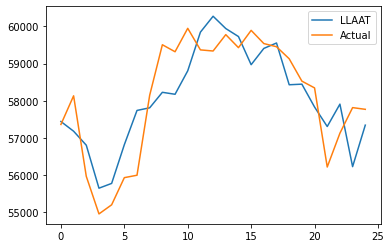

In [15]:
yo, loss, tape = network.forward()
plt.plot(sc.inverse_transform(yo)[:,0], label="LLAAT")
plt.plot(sc.inverse_transform(network.y)[:,0], label="Actual")
plt.legend()

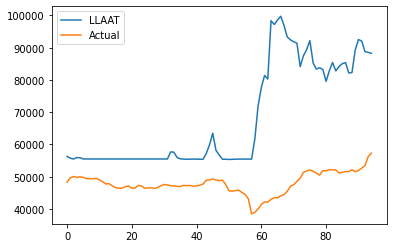

In [16]:
forecast_value = network.forecast(x_test_scaled)

plt.plot(sc.inverse_transform(forecast_value)[:,0], label="LLAAT")
plt.plot(y_test_data[:,0], label="Actual")
plt.legend()